# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Признаки:

1. DateCrawled — дата скачивания анкеты из базы
2. VehicleType — тип автомобильного кузова
3. RegistrationYear — год регистрации автомобиля
4. Gearbox — тип коробки передач
5. Power — мощность (л. с.)
6. Model — модель автомобиля
7. Kilometer — пробег (км)
8. RegistrationMonth — месяц регистрации автомобиля
9. FuelType — тип топлива
10. Brand — марка автомобиля
11. Repaired — была машина в ремонте или нет
12. DateCreated — дата создания анкеты
13. NumberOfPictures — количество фотографий автомобиля
14. PostalCode — почтовый индекс владельца анкеты (пользователя)
15. LastSeen — дата последней активности пользователя

Целевой признак:

Price — цена (евро)


## Подготовка данных

Импортируем необходимые библиотеки, модели, метрики:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor


from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV

import time

import warnings
warnings.filterwarnings("ignore")

**Рассмотрим данные:**

In [2]:
data = pd.read_csv('/datasets/autos.csv')
original_data = data.copy()

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Дубликаты и пропуски:

In [5]:
data.duplicated().sum()

4

In [6]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [7]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


**Подытог:**

В данных неправильный регистр, присутствуют дубликаты, пропуски, а также аномальные значения и выбросы. Также в данных лишние колонки, которые не пригодятся в дальнейшем исследовании. 

<div class='alert alert-success'> ✔️Отлично, первичный анализ проведен с применением диагностических инструментов Pandas, найдены особенности в данных и намечена тактика дальнейших действий.
</div>

**Проведем предобработку** 

Переведем названия столбцов в змеиный регистр: 

In [8]:
data.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower()for i in data.columns]
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

Уберем дубликаты, лишние колонки:

In [9]:
data = data.drop_duplicates()

<div class='alert alert-success'> ✔️ Хорошо, явные дубликаты удалили. Обрати внимание, что практика удаления дубликатов до фильтрации неинформативных колонок (например, DateCrawled и LastSeen) оставляет неявные дубли. Хотел подчеркнуть, что, возможно, следует дубликаты определять после удаления таких колонок, чтобы и явные, и неявные найти сразу.
</div>

In [10]:
data = data.drop(['date_crawled', 'registration_month', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen'], axis='columns') 
data.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

Изучим распределение данных, аномальные значения. Исправим:

<AxesSubplot:>

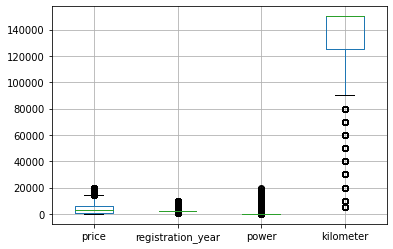

In [11]:
data.boxplot()

In [12]:
data['price'].value_counts()

0        10772
500       5670
1500      5394
1000      4648
1200      4594
         ...  
13180        1
10879        1
2683         1
634          1
8188         1
Name: price, Length: 3731, dtype: int64

In [13]:
data['registration_year'].value_counts()

2000    24490
1999    22727
2005    22109
2001    20123
2006    19900
        ...  
4100        1
1200        1
5300        1
8888        1
2290        1
Name: registration_year, Length: 151, dtype: int64

In [14]:
data['power'].value_counts()

0        40225
75       24023
60       15897
150      14590
101      13298
         ...  
323          1
3454         1
1056         1
13636        1
1158         1
Name: power, Length: 712, dtype: int64

In [15]:
data['kilometer'].value_counts()

150000    238207
125000     36453
100000     14882
90000      11567
80000      10047
70000       8593
60000       7444
5000        6397
50000       6232
40000       4911
30000       4436
20000       3974
10000       1222
Name: kilometer, dtype: int64

У признаков видны выбросы. Визуализируем и избавимся от аномалий:

In [16]:
def graf(data, x, x_label, y_label, title, bins):
    plt.figure(figsize=(13, 10))
    sns.histplot(data=data, color="g", x=x, kde=True, bins=bins)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

    plt.figure(figsize=(13, 10))
    sns.boxplot(data=data, x=x)
    plt.title(title)
    plt.xlabel(x_label)
    plt.show()

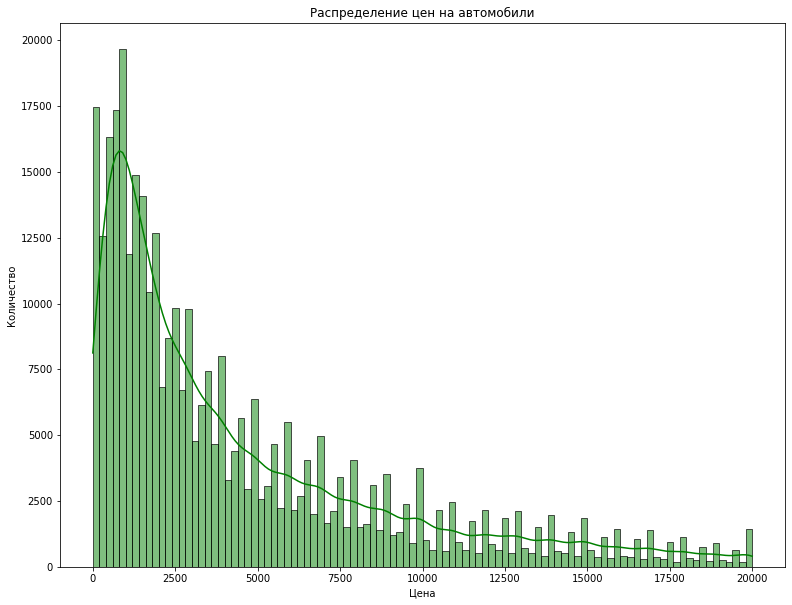

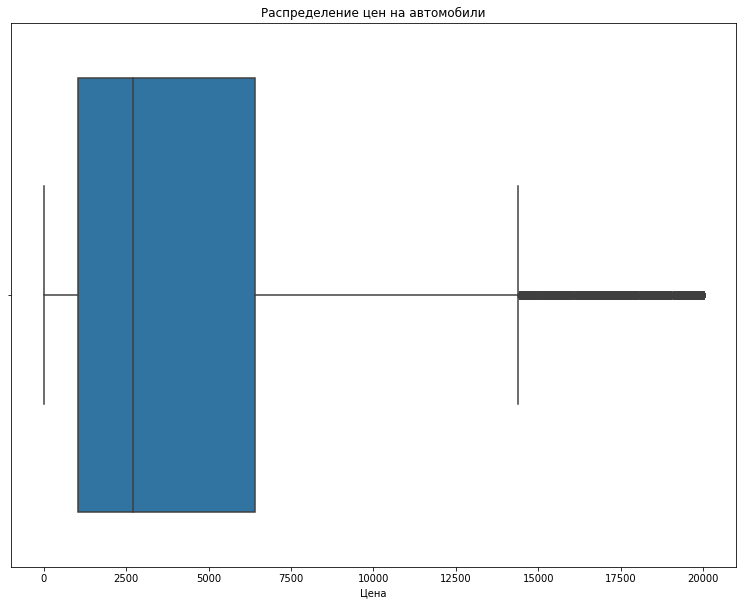

In [17]:
graf(data, 'price', 'Цена', 'Количество', 'Распределение цен на автомобили', 100)

Виден типичный правый длинный хвост. Однако много значений вокруг 0, поскольку автомобили не могут быть без цены - избавимся от этой аномалии:

In [18]:
data = data.query('price > 500')

<div class='alert alert-success'> ✔️ОК, аномалии в цене отфильтрованы
</div>

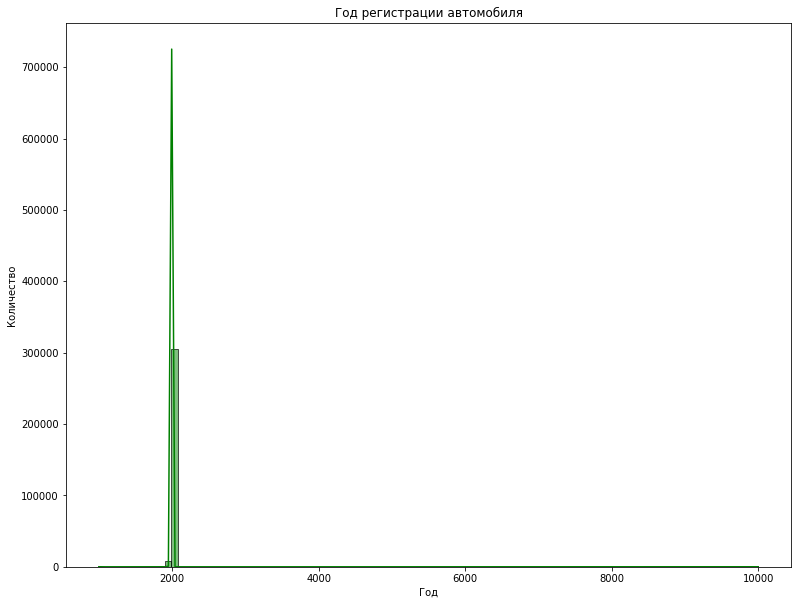

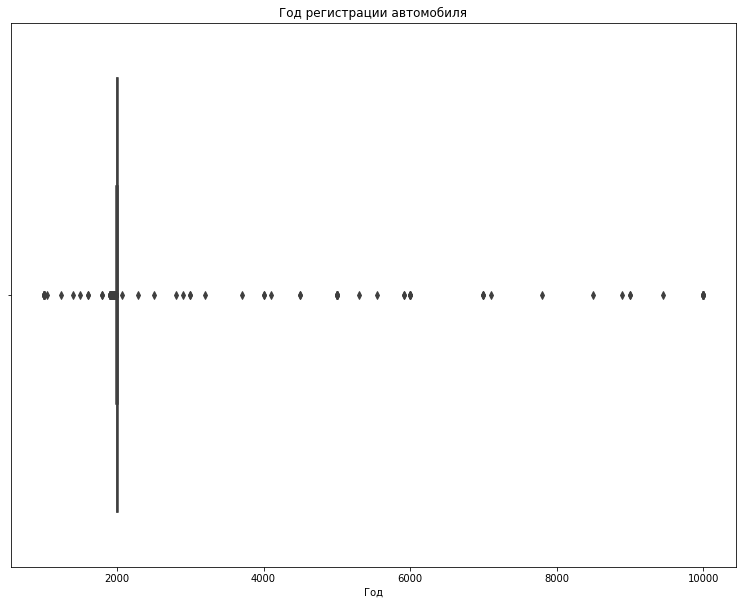

In [19]:
graf(data, 'registration_year', 'Год', 'Количество', 'Год регистрации автомобиля', 100)

Сильный разброс данных, а также явные ошибки. Необходимо учесть, что данные за 2016 год, то есть выше 2016 - аномалии. За нижний порог возмем тот год, который уже не включает раритетные и антикварные автомобили, которые могут повлиять на качество исследования. Ограничимся одним процентом: 

In [20]:
lower_limit_year = data['registration_year'].quantile(0.01)
lower_limit_year

1980.0

In [21]:
data = data.query('registration_year > 1980 and registration_year < 2016')

<div class='alert alert-success'> ✔️Отличные пределы для года регистрации
</div>

Рассмотрим мощность:

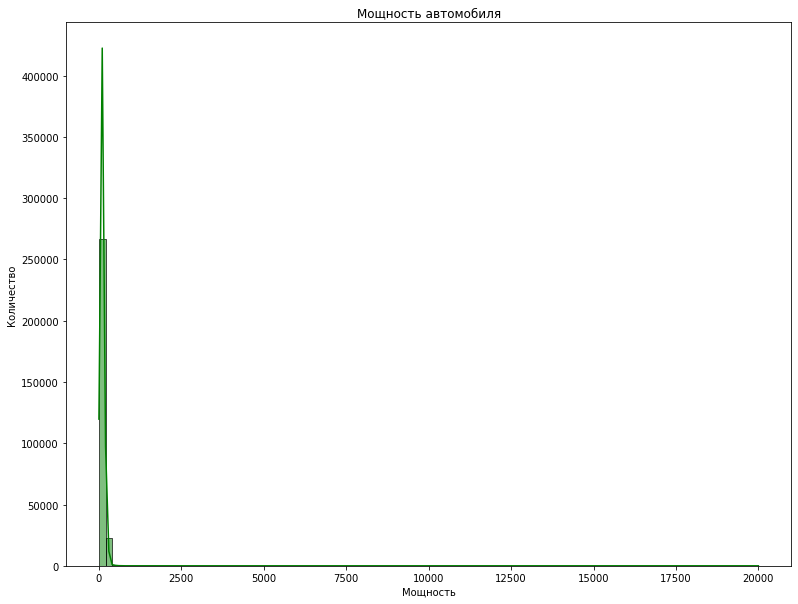

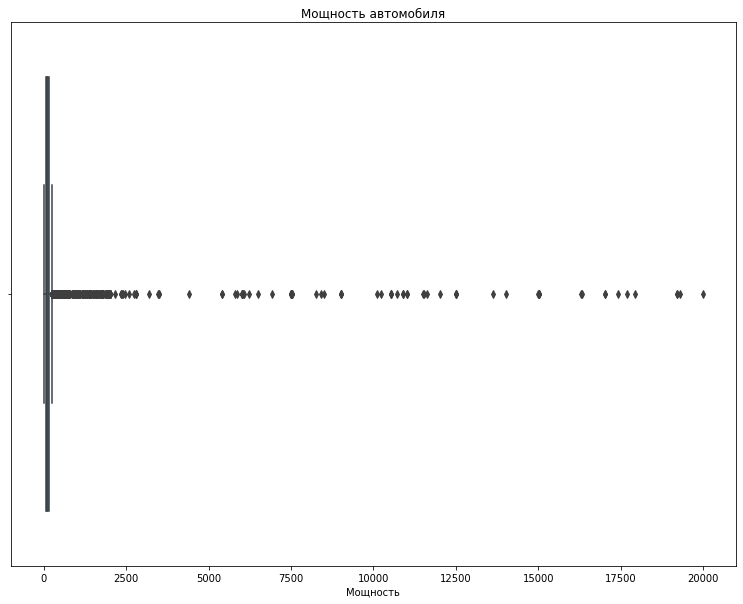

In [22]:
graf(data, 'power', 'Мощность', 'Количество', 'Мощность автомобиля', 100)

Сильный разброс, усечем выбросы больше 600 л.с., а также уберем  меньше 50 л.с. - максимальное и минимальное для автомобиля "на ходу".

In [23]:
data = data.query('power > 50 and power < 600')

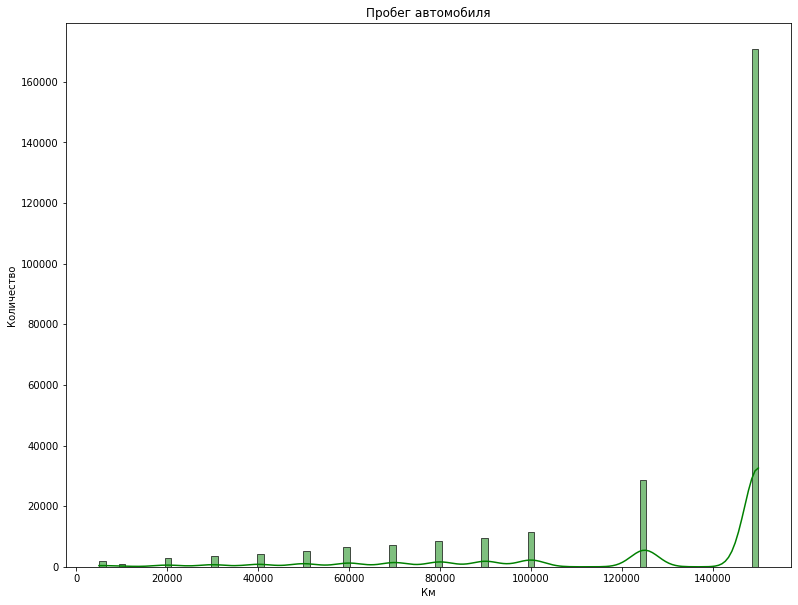

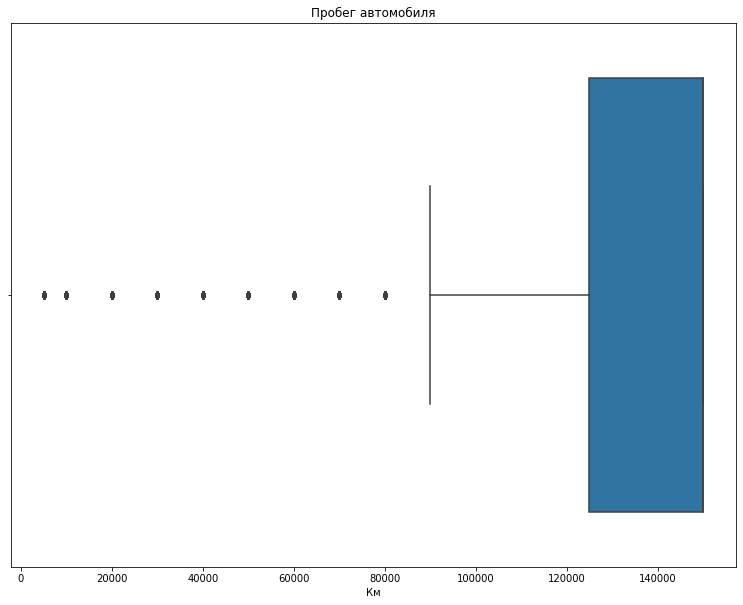

In [24]:
graf(data, 'kilometer', 'Км', 'Количество', 'Пробег автомобиля', 100)

Практически все значения лежат вокруг 150 тыс. км. Возможно при публиковании был установлен данный ограничитель.

Подробнее рассмотрим пропуски в данных и исправим:

In [25]:
data.isna().sum()

price                    0
vehicle_type          3196
registration_year        0
gearbox               3642
power                    0
model                 8014
kilometer                0
fuel_type             9788
brand                    0
repaired             32222
dtype: int64

In [26]:
data.isna().mean()

price                0.000000
vehicle_type         0.012225
registration_year    0.000000
gearbox              0.013931
power                0.000000
model                0.030654
kilometer            0.000000
fuel_type            0.037440
brand                0.000000
repaired             0.123251
dtype: float64

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261433 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              261433 non-null  int64 
 1   vehicle_type       258237 non-null  object
 2   registration_year  261433 non-null  int64 
 3   gearbox            257791 non-null  object
 4   power              261433 non-null  int64 
 5   model              253419 non-null  object
 6   kilometer          261433 non-null  int64 
 7   fuel_type          251645 non-null  object
 8   brand              261433 non-null  object
 9   repaired           229211 non-null  object
dtypes: int64(4), object(6)
memory usage: 21.9+ MB


Большинство пропусков составляет меньше 3%, можно считать незначительным, уберем их, кроме столбца repaired.

In [28]:
data.repaired.value_counts(normalize=True)

no     0.910785
yes    0.089215
Name: repaired, dtype: float64

Можно предположить, что пропуски возникли, потому что этот пункт пропускали из-за отсутвия ремонта. Заменим пропуски на no.

In [29]:
data['repaired'] = data['repaired'].fillna('no')

In [30]:
data.repaired.value_counts(normalize=True)

no     0.921781
yes    0.078219
Name: repaired, dtype: float64

In [31]:
data = data.dropna()

**Вывод:**

1. Были рассмотрены данные, проведена их предобработка;
2. Изменен регистр названия столбцов, обработаны пропуски, исключены аномальные и некорректные значения;
3. Удалены столбцы, которые не будут использованы в дальнейшем исследовании.
    

<div class='alert alert-success'> ✔️Ок, после очистки можно посмотреть взаимосвязи, например, с таблицей корреляции.
</div>


## Обучение моделей

Приведем категориальные признаки в номинальные, воспользовавшись техникой прямого кодирования

In [32]:
le = LabelEncoder()
con_columns = list(data.select_dtypes(include='object').columns)
for c in con_columns:
    le.fit(data[c].astype('str'))
    data[c] = le.transform(data[c].astype('str'))

Стандартизируем признаки:

Переведем категориальные значения столбцов в количественные:

In [34]:
data_ohe = pd.get_dummies(data, drop_first=True)

Одной из моделей будет линейная регрессия, поэтому разобьем данные для нее:

In [35]:
features_ohe = data_ohe.drop(['price'], axis = 1)
target_ohe = data_ohe['price']
features_, features_test_ohe, target_, target_test_ohe = train_test_split(features_ohe, target_ohe, test_size=0.2, random_state=12345)
features_train_ohe, features_valid_ohe, target_train_ohe, target_valid_ohe = train_test_split(
    features_, target_, test_size=.25, random_state=12345)


Стандартизируем признаки:

In [36]:
numeric = list(data_ohe)
numeric.remove('price')

In [37]:
scaler = StandardScaler()
scaler.fit(features_train_ohe[numeric])
features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric])

Посмотрим на категориальные признаки и уникальные значения:

In [38]:
categorical = ['brand','model','vehicle_type','gearbox','fuel_type']
nume_names = data.select_dtypes(include=['int64'])
data[categorical].nunique()

brand            39
model           247
vehicle_type      8
gearbox           2
fuel_type         7
dtype: int64

In [39]:
data[categorical] = data[categorical].astype('category')

Данные столбца repaired можно перевести в булев тип:

In [40]:
data['repaired'] = data['repaired'].astype('bool')

In [41]:
data.columns = data.columns.astype('category')

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241177 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   price              241177 non-null  int64   
 1   vehicle_type       241177 non-null  category
 2   registration_year  241177 non-null  int64   
 3   gearbox            241177 non-null  category
 4   power              241177 non-null  int64   
 5   model              241177 non-null  category
 6   kilometer          241177 non-null  int64   
 7   fuel_type          241177 non-null  category
 8   brand              241177 non-null  category
 9   repaired           241177 non-null  bool    
dtypes: bool(1), category(5), int64(4)
memory usage: 10.8 MB


Признаки для CatBoost и LightGBM:

In [43]:
features = data.drop(['price'], axis = 1)
target = data['price']

Разобьем выборки на обучающие и тестовые отдельно для линейной регрессии, отдельно для catboost и lightGBM:

In [44]:
features_df, features_test, target_df, target_test = train_test_split(
    features, target, test_size=.2, random_state=12345)
features_train, features_valid, target_train, target_valid = train_test_split(
    features_df, target_df, test_size=.25, random_state=12345)

Начнем с **линейной регрессии**:

In [45]:
lr_model = LinearRegression()

In [46]:
%%time

lr_model.fit(features_train_ohe, target_train_ohe)
predictions_valid_ohe = lr_model.predict(features_valid_ohe)

print('RMSE модели равно:', mean_squared_error(target_valid_ohe, predictions_valid_ohe)**0.5)


RMSE модели равно: 176008204.58038142
CPU times: user 34.6 ms, sys: 16.2 ms, total: 50.8 ms
Wall time: 70.4 ms


In [47]:
%%time

lr_model.fit(features_train, target_train)
predictions_valid = lr_model.predict(features_valid)

print('RMSE модели равно:', mean_squared_error(target_valid, predictions_valid)**0.5)

RMSE модели равно: 2730.92793418845
CPU times: user 162 ms, sys: 47 ms, total: 209 ms
Wall time: 201 ms


Масштабирование ухудшает модель.

**CatBoost.**

Подберем оптимальное значение RMSE и глубину в цикле

In [48]:
%%time

best_result = 2500
depth = 0
depths = []
results = []

for depth in range(1, 21, 5):
    cb_model = CatBoostRegressor(iterations=30, learning_rate=1, max_depth=depth, random_state=12345, verbose=5)
    cb_model.fit(features_train, target_train, cat_features=categorical)
    predictions_valid = cb_model.predict(features_valid)
    result = mean_squared_error(target_valid, predictions_valid) ** .5
    depths.append(depth)
    results.append(result)
            
    if result < best_result:
        best_depth = depth
        best_result = result


print('RMSE модели равно:', best_result, '   Глубина:', best_depth)

0:	learn: 3602.3432381	total: 78.6ms	remaining: 2.28s
5:	learn: 2801.9909587	total: 183ms	remaining: 733ms
10:	learn: 2557.6838830	total: 293ms	remaining: 507ms
15:	learn: 2381.5100194	total: 392ms	remaining: 343ms
20:	learn: 2305.8825644	total: 498ms	remaining: 213ms
25:	learn: 2269.0495130	total: 607ms	remaining: 93.4ms
29:	learn: 2248.7384203	total: 684ms	remaining: 0us
0:	learn: 2515.2838877	total: 49.4ms	remaining: 1.43s
5:	learn: 1936.6686790	total: 293ms	remaining: 1.17s
10:	learn: 1801.7300269	total: 521ms	remaining: 900ms
15:	learn: 1745.5028565	total: 736ms	remaining: 644ms
20:	learn: 1699.8454941	total: 963ms	remaining: 413ms
25:	learn: 1680.2675370	total: 1.19s	remaining: 182ms
29:	learn: 1664.6226012	total: 1.36s	remaining: 0us
0:	learn: 2311.7693227	total: 104ms	remaining: 3.01s
5:	learn: 1724.5752073	total: 581ms	remaining: 2.32s
10:	learn: 1613.1862602	total: 1.05s	remaining: 1.81s
15:	learn: 1560.4720681	total: 1.5s	remaining: 1.31s
20:	learn: 1507.3916782	total: 1.97s

**Дерево решений**.

Также создадим цикл, с помощью которого подберем дерево с минимальным RMSE:

In [49]:
%%time
best_result = 5000
depth = 0
depths = []
results = []

for depth in range(1, 21, 3):
    dt_model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    dt_model.fit(features_train, target_train)
    predictions_valid = dt_model.predict(features_valid)
    result = mean_squared_error(target_valid, predictions_valid) ** .5
    depths.append(depth)
    results.append(result)
        
            
    if result < best_result:
        best_depth = depth
        best_result = result

        
print('RMSE модели равно:', best_result, '   Глубина:', best_depth)       

RMSE модели равно: 1775.5258896156238    Глубина: 16
CPU times: user 2.34 s, sys: 0 ns, total: 2.34 s
Wall time: 2.34 s


In [50]:
%%time

dt_model = DecisionTreeRegressor(random_state=12345, max_depth=16)
dt_model.fit(features_train, target_train)
dt_predictions_valid = dt_model.predict(features_valid)
print('RMSE модели равно:', mean_squared_error(target_valid, dt_predictions_valid) ** .5)

RMSE модели равно: 1775.5258896156238
CPU times: user 458 ms, sys: 2.4 ms, total: 460 ms
Wall time: 468 ms


Установим параметры  и обучим **LightGBM**, :

In [51]:
params = {"iterations": 20,
          "learning_rate": 1,
          "max_depth": None,
          "loss_function": "RMSE",
          "random_state": 12345,
          "bootstrap_type": 'gbdt',
          "min_data_in_leaf": 1
          }

lgb_train_data = lgb.Dataset(features_train, label=target_train)

arguments = {'learning_rate': 1,
         'metric': 'rmse',
         'seed': 12345,
         'objective': 'regression',
         'verbosity': -1,
        }

max_depth = [1, 6, 11]

In [52]:
best_score = 2500
for depth in max_depth:
    arguments['max_depth'] = depth
    score = lgb.cv(arguments, lgb_train_data, nfold=3, categorical_feature=categorical)
    score = pd.DataFrame(score).iloc[-1]['rmse-mean']
    if score < best_score:
        best_score = score
        best_depth = depth
params['max_depth'] = best_depth

In [53]:
%%time

params['max_depth'] = best_depth
lgb_model = lgb.train(arguments, lgb_train_data, categorical_feature=categorical, num_boost_round=400)

print('RMSE модели равно:', best_score, '   Глубина:', best_depth) 

RMSE модели равно: 1628.6547296462213    Глубина: 6
CPU times: user 10.8 s, sys: 0 ns, total: 10.8 s
Wall time: 10.8 s


**Посмотрим на время время обучения и предсказания для каждой модели:**

**Модель решающего дерева:**

In [54]:
%%time
# найдем время обучения модели решающего дерева
dt_model = DecisionTreeRegressor(random_state=12345, max_depth=16)
dt_model.fit(features_train, target_train)

CPU times: user 432 ms, sys: 0 ns, total: 432 ms
Wall time: 436 ms


DecisionTreeRegressor(max_depth=16, random_state=12345)

In [55]:
%%time
#построим предсказания на тренировочной выборке и найдем скорость
predictions_valid = dt_model.predict(features_valid)

CPU times: user 34.7 ms, sys: 0 ns, total: 34.7 ms
Wall time: 32.9 ms


**Линейная регрессия:**

In [56]:
%%time

lr_model = LinearRegression()
lr_model.fit(features_train, target_train)

CPU times: user 102 ms, sys: 0 ns, total: 102 ms
Wall time: 117 ms


LinearRegression()

In [57]:
%%time

predictions_valid = lr_model.predict(features_valid)

CPU times: user 52.8 ms, sys: 0 ns, total: 52.8 ms
Wall time: 25.1 ms


**Catboost**

In [58]:
%%time

cb_model = CatBoostRegressor(iterations=30, learning_rate=1, max_depth=16, random_state=12345, verbose=5)
cb_model.fit(features_train, target_train, cat_features=categorical)

0:	learn: 2244.4662902	total: 783ms	remaining: 22.7s
5:	learn: 1561.2336847	total: 5.32s	remaining: 21.3s
10:	learn: 1447.0468518	total: 8.93s	remaining: 15.4s
15:	learn: 1358.8539919	total: 13.4s	remaining: 11.7s
20:	learn: 1310.3349190	total: 18.1s	remaining: 7.75s
25:	learn: 1274.4138583	total: 22.6s	remaining: 3.48s
29:	learn: 1237.7540276	total: 26.3s	remaining: 0us
CPU times: user 20.9 s, sys: 5.57 s, total: 26.4 s
Wall time: 27.1 s


In [59]:
%%time

predictions_valid = cb_model.predict(features_valid)

CPU times: user 46.3 ms, sys: 6.65 ms, total: 52.9 ms
Wall time: 53.2 ms


**LightGBM**

In [60]:
%%time

model = lgb.LGBMRegressor(random_state=12345, max_depth = 6, learning_rate = 1)
model.fit(features_train, target_train)

CPU times: user 3.13 s, sys: 0 ns, total: 3.13 s
Wall time: 3.08 s


LGBMRegressor(learning_rate=1, max_depth=6, random_state=12345)

In [61]:
%%time

predictions_valid = model.predict(features_valid)

CPU times: user 441 ms, sys: 0 ns, total: 441 ms
Wall time: 407 ms


## Анализ моделей

Сведем полученные данные в таблицу и проанализируем результаты:

In [63]:
results = {
    'Модель' : ['Линейная регрессия', 'CatBoost', 'Дерево решений', 'LightGBM'],
    'RMSE' :pd.Series([2730, 1596.5, 1775.5, 1628.6]),
    'Время обучения , sec': pd.Series([0.11, 27, 0.52, 3.08]),
    'Время предсказания , sec': pd.Series([0.02, 0.05, 0.03, 0.4])
}
print(pd.DataFrame(results))

               Модель    RMSE  Время обучения , sec  Время предсказания , sec
0  Линейная регрессия  2730.0                  0.11                      0.02
1            CatBoost  1596.5                 27.00                      0.05
2      Дерево решений  1775.5                  0.52                      0.03
3            LightGBM  1628.6                  3.08                      0.40


Лучшие RMSE у CatBoost, проверим на тестовой выборке:

In [64]:
%%time

cb_model = CatBoostRegressor(iterations=30, learning_rate=1, max_depth=16, random_state=12345, verbose=5)
cb_model.fit(features_df, target_df, cat_features=categorical)
cb_predictions_test= cb_model.predict(features_test)
print('RMSE на тестовой выборке: ', mean_squared_error(target_test, cb_predictions_test) ** .5)

0:	learn: 2194.5593320	total: 1.04s	remaining: 30.3s
5:	learn: 1568.5049255	total: 5.68s	remaining: 22.7s
10:	learn: 1433.3673318	total: 10.4s	remaining: 18s
15:	learn: 1359.0592738	total: 15.1s	remaining: 13.2s
20:	learn: 1310.2943612	total: 19.7s	remaining: 8.45s
25:	learn: 1269.1214031	total: 24.4s	remaining: 3.75s
29:	learn: 1242.9920367	total: 28.1s	remaining: 0us
RMSE на тестовой выборке:  1571.6587930368432
CPU times: user 22.6 s, sys: 5.92 s, total: 28.5 s
Wall time: 28.9 s


**Вывод:**
1. Самое высокое качество предсказания у модели CatBoost, которой лишь немного уступает LightGBM;
2. По времени предсказаний лидирует модель LinearRegression, но модель показала себя слабо из-за низкого RMSE;
3. Время предсказаний у моделей LightGBM и Catboost примерно одинаково. Хоть и модели CatBoost времени обучения выше, чем у LightGBM, первая обладает большими перспективами при подборе гиперпараметров.


